**Don't forget kaggle.json file**

Steps to download Kaggle datasets in Google Colab

https://www.kaggle.com/general/156610

In [175]:
!nividia-smi

/bin/bash: nividia-smi: command not found


In [176]:
!cp /content/drive/MyDrive/colab_data/kaggle.json /root/.kaggle/kaggle.json
!kaggle datasets download -d tthien/shanghaitech 
!unzip -q shanghaitech.zip

shanghaitech.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [177]:
import numpy as np
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

In [178]:
plt.rcParams["figure.figsize"] = (20,10)

# EDA

In [179]:
x_folder = Path('/content/ShanghaiTech/part_B/train_data/images')
filename = x_folder / 'IMG_1.jpg'
image = Image.open(filename, mode='r')


In [180]:
image_np = np.asarray(image)


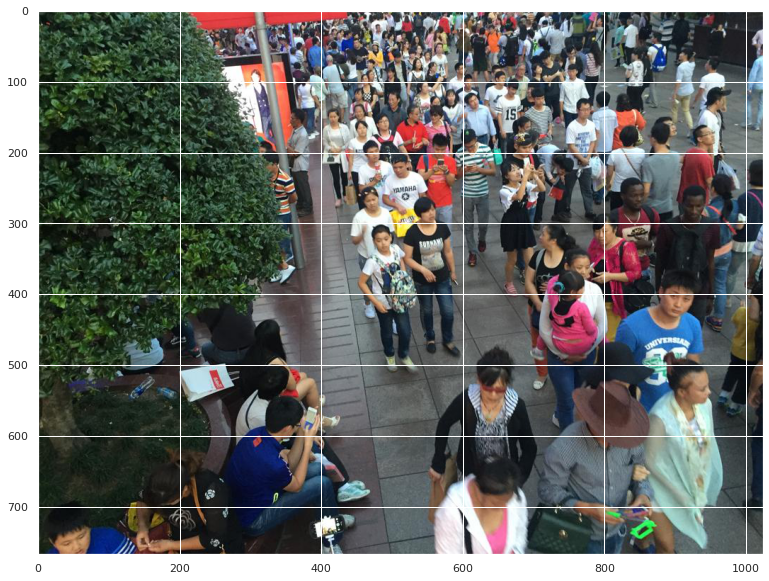

In [181]:
plt.imshow(image_np)

In [182]:
y_folder = Path('/content/ShanghaiTech/part_B/train_data/ground-truth')
filename = y_folder / 'GT_IMG_1.mat'
mat = scipy.io.loadmat(filename)


In [183]:
# x label
print(type(mat['image_info'][0][0][0][0][0]))
print(mat['image_info'][0][0][0][0][0].shape)
print(repr(mat['image_info'][0][0][0][0][0][:10]))

<class 'numpy.ndarray'>
(233, 2)
array([[ 32.67954877, 753.52165403],
       [184.60695349, 690.79933098],
       [344.89733461, 577.8991495 ],
       [328.1713818 , 536.08426746],
       [329.5652112 , 473.36194441],
       [643.17682645, 533.29660866],
       [661.29660866, 681.04252518],
       [803.46720757, 580.6868083 ],
       [814.61784278, 502.63236184],
       [757.47083734, 392.51983915]])


In [184]:
# total number of the people
print(repr(mat['image_info'][0][0][0][0][1]))
print(type(mat['image_info'][0][0][0][0][1]))

array([[233]], dtype=uint8)
<class 'numpy.ndarray'>


In [185]:
def get_points(mat):
  return mat['image_info'][0][0][0][0][0]


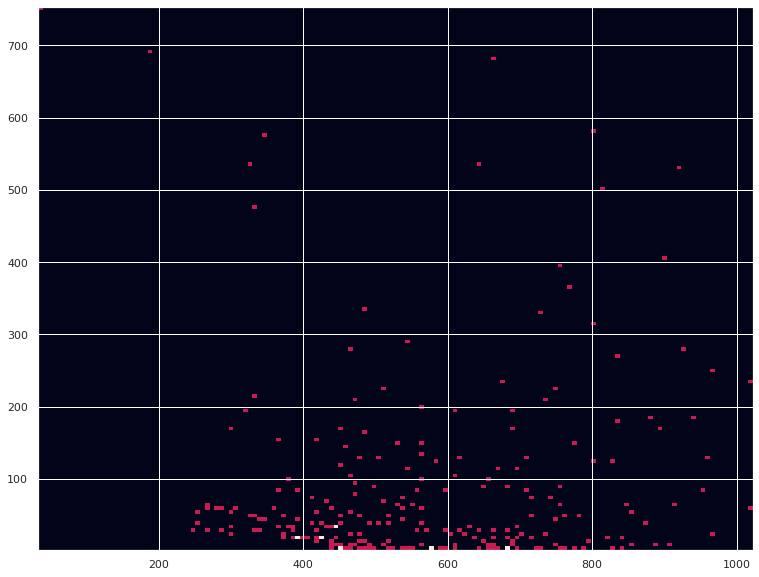

In [186]:
# heapmap

x, y = list(zip( *get_points(mat) ))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=150)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [219]:
import math
def drawHeatMap(points, height, width, scale=1):
  if scale > 1:
    print("Warning: scale usually <1 but now is {scale}")

  heatmap_shape = (round(height*scale), round(width*scale))
  heatmap = np.zeros( heatmap_shape, dtype=float )
  points *= scale
  for point in points:
    x = math.floor(point[0])
    y = math.floor(point[1])
    heatmap[y][x] += 1

  return heatmap




In [220]:
heatmap = drawHeatMap(get_points(mat), 768, 1024, 0.25)

In [222]:
np.sum(heatmap)

233.0

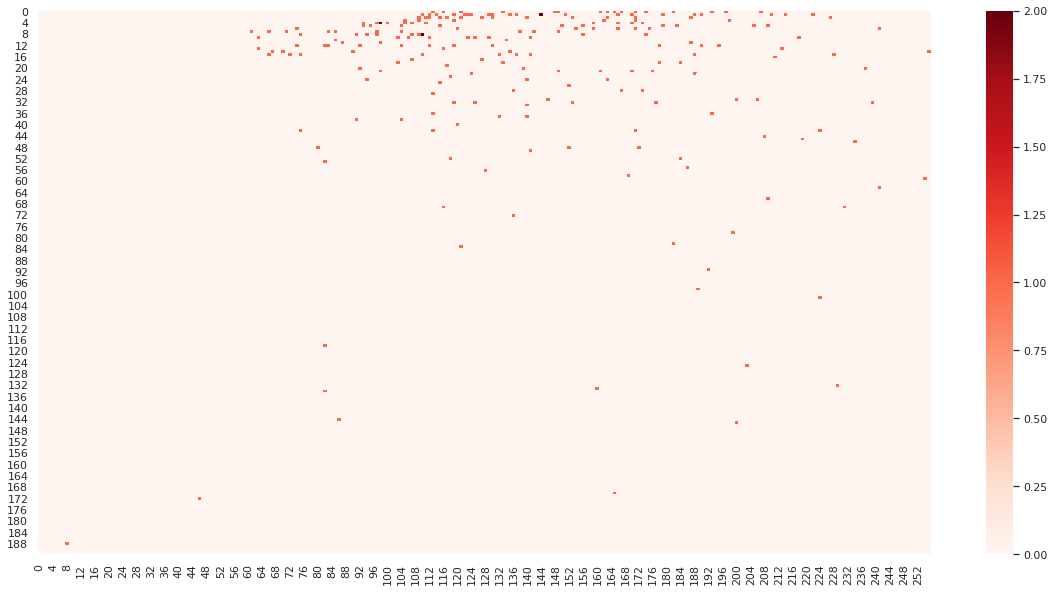

In [286]:
import seaborn as sns 
sns.set_theme()

uniform_data = np.random.rand(15, 20)

ax = sns.heatmap(heatmap, cmap="Reds")

# ax = sns.heatmap(get_points(mat), cmap="YlGnBu")

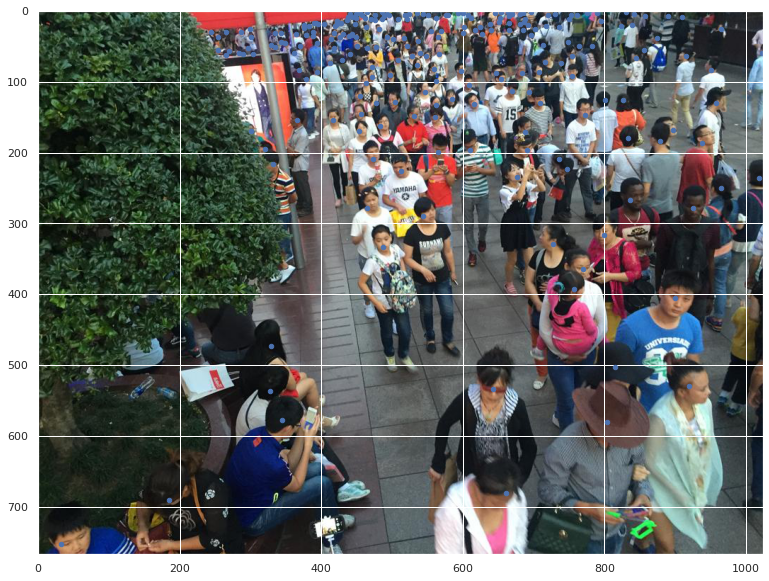

In [210]:
plt.imshow(image_np)
plt.scatter(x, y, s=20)

# Define Dataset

In [246]:
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as trans_F
import os


In [304]:
class ImageLabelRandomCrop(transforms.RandomCrop):
  @staticmethod
  def getBoundChecker(h, w):
    def isInbound(location):
      pw, ph = location
      return True if \
        (ph > 0) and (ph < h) and (pw > 0) and (pw < w) \
        else False
    return isInbound



  def forward(self, img, label):
    """
    Args:
        img (PIL Image or Tensor): Image to be cropped.

    Returns:
        PIL Image or Tensor: Cropped image.
    """
    if self.padding is not None:
        img = trans_F.pad(img, self.padding, self.fill, self.padding_mode)

    _, height, width = trans_F.get_dimensions(img)
    # pad the width if needed
    if self.pad_if_needed and width < self.size[1]:
        padding = [self.size[1] - width, 0]
        img = trans_F.pad(img, padding, self.fill, self.padding_mode)
    # pad the height if needed
    if self.pad_if_needed and height < self.size[0]:
        padding = [0, self.size[0] - height]
        img = trans_F.pad(img, padding, self.fill, self.padding_mode)

    i, j, h, w = self.get_params(img, self.size)

    label[:,0] -= j
    label[:,1] -= i

    inbound_checker = self.getBoundChecker(h, w)
    new_label = list(filter(inbound_checker, label))

    return trans_F.crop(img, i, j, h, w), new_label



class ShanghaiTechPartBDataset(Dataset):
  """
  @param dataset_folder - the path to the dataset folder which contains
      "test_data" and "train_data"
  @param image_size - output size of the `X`. If the input resolution 
            is too large, the image will be cropped. The format
            of the input is (`height`, `width`)
  @param train - choose between "train_data" and "test_data"

  Example Usage
    dataset = ShanghaiTechPartBDataset("/content/ShanghaiTech/part_B", image_size=(512,512), train=True)
  """
  def __init__(self, dataset_folder, image_size=(512,512), train=True ):
    self.dataset_path = Path(dataset_folder) / ('train_data' if train else 'test_data')
    self.images_path = self.dataset_path / 'images'
    self.y_path = self.dataset_path / 'ground-truth'
    self.image_size = image_size
    if image_size is None:
      # use original resolution
      self.cropFn = None
    else:
      self.cropFn = ImageLabelRandomCrop(size=image_size)
    
    self.images_list = os.listdir(self.images_path)
    y_list = []
    for image_name in self.images_list:
      y_name = 'GT_' + image_name.split('.')[0] + '.mat'

      # file check
      try:
        os.lstat(self.y_path / y_name)
      except FileNotFoundError as e:
        raise e

      y_list.append(y_name)

    self.y_list = y_list

  def __len__(self):
    return len(self.images_list)

  def __getitem__(self, index):
    image_path = self.images_path / self.images_list[index]
    y_path = self.y_path / self.y_list[index]

    image = Image.open(image_path, mode='r')
    mat = scipy.io.loadmat(y_path)
    y = mat['image_info'][0][0][0][0][0]

    if self.image_size is not None:
      image, y = self.cropFn(image, y)

    image = np.asarray(image)
    image = np.transpose(image, (2,0,1))
    y = np.asarray(y)

    return image, y

In [305]:
dataset = ShanghaiTechPartBDataset("/content/ShanghaiTech/part_B", image_size=(512,512), train=True)

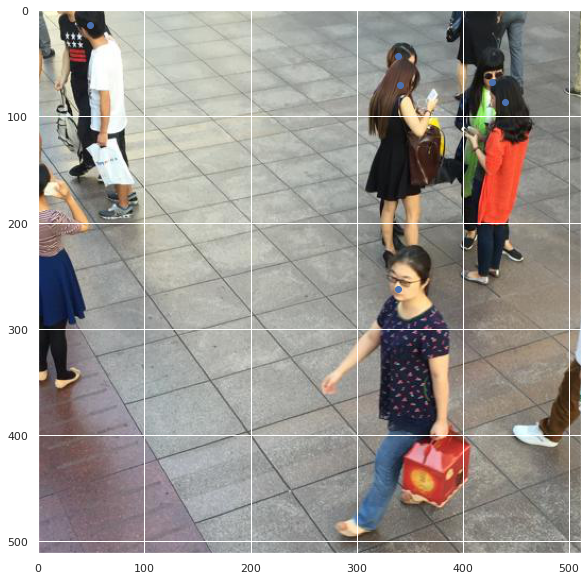

In [306]:
data = dataset[0]
plt.imshow( np.transpose(data[0], (1,2,0)) )
x_data, y_data = zip(*data[1])
plt.scatter(x_data, y_data)

# Define Model

In [307]:
from torch import nn
import torch


In [327]:
class CrowdNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.lrCNN1 = nn.Sequential(
        nn.Conv2d(3, 64, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=1, padding=1),
        nn.ReLU(),
        
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=1, padding=1),
        nn.ReLU(),

        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, 3, stride=1, padding=1),
        nn.ReLU(),
    )
    self.lrCNN2 = nn.Sequential(
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 196, 7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv2d(196, 96, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.Conv2d(96, 32, 3, stride=1, padding=1),
        nn.ReLU(),
    )
    self.LR = nn.Conv2d(32, 1, 1, 1)

    self.hrCNN1 = nn.Sequential(
        nn.Conv2d(3, 16, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 24, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(24, 48, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(48, 48, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(48, 24, 3, stride=1, padding=1),
        nn.ReLU(),
    )
    self.hrCNN2 = nn.Sequential(
        nn.Conv2d(281, 196, 7, stride=1, padding=3),
        nn.ReLU(),
        nn.Conv2d(196, 96, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(96, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear'),
    )
    self.HR = nn.Conv2d(32, 1, 1, 1)


  def forward(self, x):
    lr_feat_map1 = self.lrCNN1(x)
    lr_feat_map2 = self.lrCNN2(lr_feat_map1)
    lr_heat_map = self.LR(lr_feat_map2)

    hr_feat_map1 = self.hrCNN1(x)
    hr_feat_map1 = torch.concat(
        (lr_feat_map1, lr_heat_map, hr_feat_map1), dim=1
    )
    hr_feat_map2 = self.hrCNN2(hr_feat_map1)
    hr_heat_map = self.HR(hr_feat_map2)

    return torch.squeeze(lr_heat_map, dim=1), \
        torch.squeeze(hr_heat_map, dim=1)

In [374]:
crowdnet = CrowdNet()
data = dataset[0]
image = torch.tensor([data[0]], dtype=torch.float32)
print(image.shape, image.dtype)
print(len(data[1]))
out = crowdnet(image)


torch.Size([1, 3, 512, 512]) torch.float32
7


In [ ]:
out

In [ ]:
plt.imshow(np.transpose( data[0], (1,2,0) ))
x_data, y_data = zip(*data[1])
plt.scatter(x_data, y_data)

In [ ]:
ax = sns.heatmap(out[0].detach().numpy()[0], cmap="Reds")

In [ ]:
ax = sns.heatmap(out[1].detach().numpy()[0], cmap="Reds")

# Loss Function

In [334]:
import torch.nn.functional as nn_F

In [397]:
class CrowdNetLoss(nn.Module):
  def __init__(self, lambda_l, lambda_h):
    super().__init__()
    self.lambda_l = lambda_l
    self.lambda_h = lambda_h

  def forward(self, lr_pred_y, hr_pred_y, lr_y, hr_y):
    lr_loss = nn_F.mse_loss(lr_pred_y, lr_y)
    hr_loss = nn_F.mse_loss(hr_pred_y, hr_y)
    return self.lambda_l * lr_loss + self.lambda_h * hr_loss

In [ ]:
np.asarray(data[1])

In [ ]:
print(data[1])

sns.heatmap(drawHeatMap(data[1], 512, 512, 0.25), cmap="Reds")

In [395]:
loss_fn = CrowdNetLoss(0.5, 0.5)
lr_y = drawHeatMap(data[1], 512, 512, 0.25)
hr_y = drawHeatMap(data[1], 512, 512, 1)
lr_y = torch.tensor([lr_y], dtype=torch.float32)
hr_y = torch.tensor([hr_y], dtype=torch.float32)
loss_v = loss_fn(out[0], out[1], lr_y, hr_y)

torch.float32
torch.float32


In [342]:
loss_v

tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>)

# Integration Test

In [398]:
from torch import optim
crowdnet = CrowdNet()
optimizer = optim.SGD(crowdnet.parameters(), lr=0.01)
loss_fn = CrowdNetLoss(0.5, 0.5)

In [479]:
data = dataset[0]
image = torch.tensor([data[0]], dtype=torch.float32)
print(image.shape, image.dtype)
print(len(data[1]))
optimizer.zero_grad()
out = crowdnet(image)


torch.Size([1, 3, 512, 512]) torch.float32
1


In [480]:
lr_y = drawHeatMap(data[1], 512, 512, 0.25)
hr_y = drawHeatMap(data[1], 512, 512, 1)
lr_y = torch.tensor([lr_y], dtype=torch.float32)
hr_y = torch.tensor([hr_y], dtype=torch.float32)
loss_v = loss_fn(out[0], out[1], lr_y, hr_y)

In [458]:
loss_v.dtype

torch.float32

In [481]:
print(loss_v)

tensor(0.0026, grad_fn=<AddBackward0>)


In [477]:
loss_v.backward()
optimizer.step()

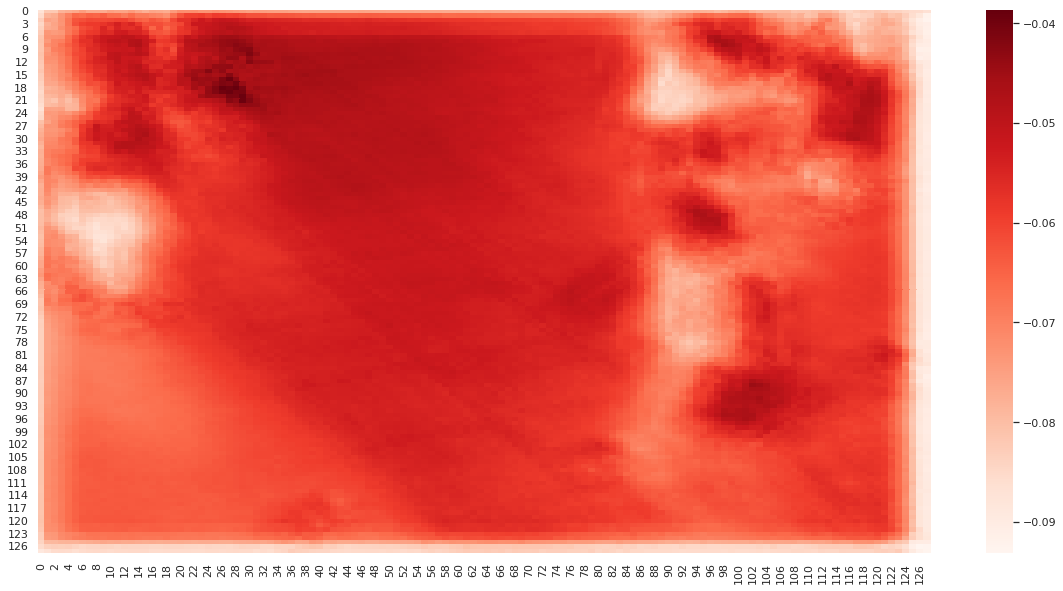

In [478]:
sns.heatmap(out[0][0].detach().numpy(), cmap="Reds")

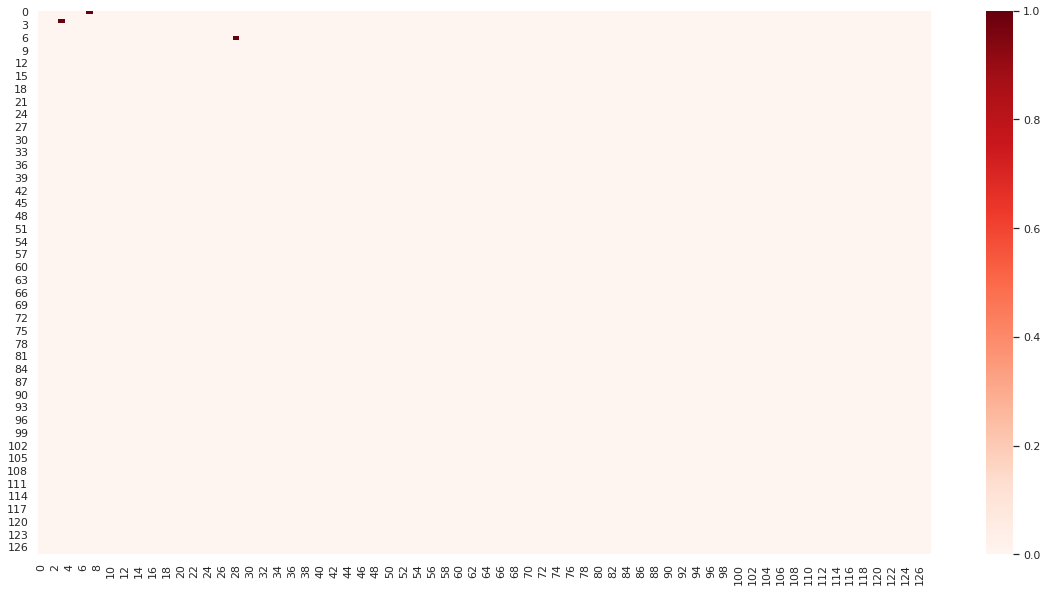

In [427]:
sns.heatmap(drawHeatMap(data[1], 512, 512, 0.25), cmap="Reds")

# Train

In [224]:
# from tqdm import tqdm
from tqdm.notebook import tqdm
import copy
import time

In [223]:
DEVICE = torch.device('cpu')

In [225]:
@torch.no_grad()
def val_acc(m, loss_fn, valloader):
  total_num = 0
  correct_num = 0
  loss_list = []
  m = m.eval()
  for x, y in valloader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = m(x)
    
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.item())

    y_pred = torch.argmax(y_pred, dim=1)
    correct_num += torch.sum( (y_pred == y)*1 ).item()
    total_num += len(y)

  return correct_num / total_num, sum(loss_list) / len(loss_list)

def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None, best_epoch_start=200):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_acc_list = []
  val_acc_v = 0.
  val_loss = 0.
  best_model = copy.deepcopy(m.state_dict())
  best_val_acc = 0.
  best_epoch = best_epoch_start
  total_time = 0.
  for i in pbar:
    sub_loss_list = []

    m = m.train()
    start = time.time()
    for x, y in trainloader:
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      lr_pred, hr_pred = m(x)


      lr_y = drawHeatMap(data[1], 512, 512, 0.25)
      hr_y = drawHeatMap(data[1], 512, 512, 1)
      lr_y = torch.tensor([lr_y])
      hr_y = torch.tensor([hr_y])


      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 

      loss.backward()
      optimizer.step()

    end = time.time()
    
    total_time = total_time + (end - start)
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    if valloader is not None:
      # del x; del y # free some GPU memory
      val_acc_v, val_loss = val_acc(m, loss_fn, valloader)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 
      val_acc_list.append(val_acc_v)
      if (i > best_epoch) and (val_acc_v > best_val_acc):
        best_epoch = i
        best_val_acc = val_acc_v
        best_model = copy.deepcopy(m.state_dict())

  print(f'\ntraining finished in {total_time}s. Best model at epoch={best_epoch} with val_acc={best_val_acc}')
  m.load_state_dict(best_model)
  return loss_list, val_acc_list

In [380]:
a = torch.tensor([1,2,3], dtype=torch.float32)

In [381]:
a.dtype


torch.float32

In [384]:
(0.5*a+0.5*a).dtype

torch.float32